In [1]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from transformers import AutoModel, AutoTokenizer
from plotnine import (
    ggplot, aes, geom_bar, facet_wrap, theme_bw, element_text,
    labs, ylim, theme
)
from pandas.api.types import CategoricalDtype
from IPython.display import display

def get_cls_attention_per_layer(model, input_ids, attention_mask):
    outputs = model(input_ids=input_ids, attention_mask=attention_mask, output_attentions=True)
    attentions = outputs.attentions  # (num_layers) of (1, heads, seq_len, seq_len)

    cls_attns = []
    for layer_attn in attentions:
        #cls_attn = layer_attn[0, :, 0, :]  # (heads, seq_len)
        cls_attn = layer_attn[0, :, :, 0]
        avg_cls_attn = cls_attn.mean(dim=0)  # (seq_len,)
        cls_attns.append(avg_cls_attn.detach().cpu().numpy())

    return cls_attns

def plot_comparative_cls_attention_ggplot(all_cls_attns, tokens_list, model_names):
    data = []

    # Debug: Check the actual number of layers for each model
    print(f"Checking layer counts per model:")
    for model_idx, model_attns in enumerate(all_cls_attns):
        num_layers_this_model = len(model_attns)
        print(f"  {model_names[model_idx]}: {num_layers_this_model} layers")

    # Use the actual number of layers from the data
    num_layers = len(all_cls_attns[0])  # Use first model as reference
    print(f"Using {num_layers} layers as reference")

    for layer_idx in range(num_layers):
        for model_idx, model_attns in enumerate(all_cls_attns):
            # Check if this model has this layer
            if layer_idx >= len(model_attns):
                print(f"Warning: {model_names[model_idx]} doesn't have layer {layer_idx+1}")
                continue

            attn = model_attns[layer_idx]
            tokens = tokens_list[model_idx]

            min_len = min(len(attn), len(tokens))
            attn = attn[:min_len]
            tokens = tokens[:min_len]

            for pos, (token, weight) in enumerate(zip(tokens, attn)):
                weight = float(weight)

                data.append({
                    "Token": token,
                    "Attention": weight,
                    "Model": model_names[model_idx],
                    "Layer": f"Layer {layer_idx+1:02d}",  # Back to 1-based indexing for display
                    "Position": pos,
                    "LayerNum": layer_idx + 1
                })

    df = pd.DataFrame(data)

    # Debug: Check which layers actually have data in the dataframe
    actual_layers_in_df = sorted(df['Layer'].unique())
    expected_layers = [f"Layer {i:02d}" for i in range(1, num_layers + 1)]

    print(f"\nLayer alignment check:")
    print(f"Expected layers: {expected_layers}")
    print(f"Actual layers in df: {actual_layers_in_df}")
    print(f"Missing layers: {set(expected_layers) - set(actual_layers_in_df)}")

    # Check data distribution across layers and models
    layer_model_counts = df.groupby(['Layer', 'Model']).size().unstack(fill_value=0)
    print(f"\nData counts per layer-model combination:")
    print(layer_model_counts)

    # Use only the layers that actually exist in the data
    actual_num_layers = len(actual_layers_in_df)
    expected_layers_0based = [f"Layer {i:02d}" for i in range(actual_num_layers)]
    print(f"Expected 0-based layers: {expected_layers_0based}")
    print(f"\nUsing {actual_num_layers} actual layers for analysis")

    # Create a simplified position-based grouping
    # Use position as the primary x-axis, let dodge handle model separation
    df["PosLabel"] = df["Position"].astype(str)

    # For better readability, create position labels with the most common token at that position
    pos_labels = {}
    for pos in df["Position"].unique():
        pos_tokens = df[df["Position"] == pos]["Token"].tolist()
        # Get the most common token at this position (or first one if tie)
        most_common_token = max(set(pos_tokens), key=pos_tokens.count)
        pos_labels[pos] = f"{pos}:{most_common_token}"

    df["PosLabel"] = df["Position"].map(pos_labels)

    # Create ordered categorical by position
    ordered_positions = sorted(df["Position"].unique())
    ordered_labels = [pos_labels[pos] for pos in ordered_positions]
    df["PosLabel"] = pd.Categorical(df["PosLabel"], categories=ordered_labels, ordered=True)

    # Create a complete grid to ensure all layers have all possible positions
    all_positions = df['Position'].unique()
    all_layers = actual_layers_in_df

    complete_grid = []
    for layer in all_layers:
        for pos in all_positions:
            if len(df[(df['Layer'] == layer) & (df['Position'] == pos)]) == 0:
                # Add dummy row with 0 attention for missing combinations
                complete_grid.append({
                    'Layer': layer,
                    'Position': pos,
                    'PosLabel': pos_labels[pos],
                    'Attention': 0.0,  # Explicit float
                    'Model': 'dummy',
                    'Token': 'dummy',
                    'LayerNum': int(layer.split()[1])
                })

    if complete_grid:
        print(f"Adding {len(complete_grid)} dummy rows for missing position-layer combinations")
        dummy_df = pd.DataFrame(complete_grid)
        df = pd.concat([df, dummy_df], ignore_index=True)
        print(f"Dataframe shape after adding dummy rows: {df.shape}")

    # Recreate categorical after adding dummy data
    df["PosLabel"] = pd.Categorical(df["PosLabel"], categories=ordered_labels, ordered=True)

    # Replace any remaining NaN values with 0
    df['Attention'] = df['Attention'].fillna(0.0)

    # Also make Layer categorical in the main dataframe - use actual layers only
    df["Layer"] = pd.Categorical(df["Layer"], categories=actual_layers_in_df, ordered=True)

    # Debug the exact categorical levels
    print(f"\nDetailed categorical analysis:")
    print(f"Main df PosLabel categories (first 10): {df['PosLabel'].cat.categories[:10].tolist()}")
    print(f"Main df PosLabel categories (last 10): {df['PosLabel'].cat.categories[-10:].tolist()}")
    print(f"Total PosLabel categories: {len(df['PosLabel'].cat.categories)}")

    # Final check before plotting
    print(f"\nBefore plotting:")
    print(f"Main df final shape: {df.shape}")
    print(f"Unique layers in main df: {df['Layer'].unique()}")
    print(f"Missing values in plotting columns:")
    print(f"  PosLabel: {df['PosLabel'].isnull().sum()}")
    print(f"  Attention: {df['Attention'].isnull().sum()}")
    print(f"  Model: {df['Model'].isnull().sum()}")
    print(f"  Layer: {df['Layer'].isnull().sum()}")

    # Find the single highest activation across ALL models for each layer (excluding [CLS] and [SEP])
    global_max_activations = []

    for layer_name in actual_layers_in_df:
        layer_data = df[df["Layer"] == layer_name]

        if layer_data.empty:
            print(f"{layer_name}: No data found!")
            continue

        # Try multiple filtering approaches
        # Approach 1: Strict filtering for [CLS] and [SEP]
        filtered_layer_data = layer_data[
            ~layer_data["Token"].str.upper().str.contains(r'CLS|SEP', case=False, na=False, regex=True)
        ]

        # Approach 2: If no data after strict filtering, try excluding only exact matches
        if filtered_layer_data.empty:
            filtered_layer_data = layer_data[
                ~layer_data["Token"].isin(['[CLS]', '[SEP]', '[cls]', '[sep]', 'CLS', 'SEP'])
            ]

        # Approach 3: If still no data, just find the overall maximum (include everything)
        if filtered_layer_data.empty:
            filtered_layer_data = layer_data
            print(f"{layer_name}: Using all tokens (no filtering worked)")
        else:
            print(f"{layer_name}: Successfully filtered, {len(filtered_layer_data)} rows remaining")

        if not filtered_layer_data.empty:
            # Find the absolute maximum across all models in this layer
            max_idx = filtered_layer_data["Attention"].idxmax()
            global_max_row = filtered_layer_data.loc[max_idx]

            global_max_activations.append({
                "Layer": layer_name,
                "LayerNum": int(layer_name.split()[1]),  # Extract layer number (now 0-based)
                "Position": global_max_row["Position"],
                "PosLabel": global_max_row["PosLabel"],
                "Attention": global_max_row["Attention"],
                "Token": global_max_row["Token"],
                "Model": global_max_row["Model"]
            })
            print(f"{layer_name}: Max found - {global_max_row['Model']} at {global_max_row['Token']} = {global_max_row['Attention']:.4f}")
        else:
            print(f"{layer_name}: No data available even after fallback!")

    global_max_df = pd.DataFrame(global_max_activations)
    print(f"\nTotal layers with triangles: {len(global_max_df)} out of {num_layers}")

    # Ensure PosLabel categories match between main df and global_max_df
    if not global_max_df.empty:
        # Make sure global_max_df uses the same categorical levels as the main df
        global_max_df["PosLabel"] = pd.Categorical(
            global_max_df["PosLabel"],
            categories=df["PosLabel"].cat.categories,
            ordered=True
        )

        # Ensure Layer categories also match exactly
        global_max_df["Layer"] = pd.Categorical(
            global_max_df["Layer"],
            categories=df["Layer"].cat.categories,
            ordered=True
        )

        # Debug: check alignment
        print(f"Main df layers: {sorted(df['Layer'].cat.categories)}")
        print(f"Global max layers: {sorted(global_max_df['Layer'].unique())}")

        # Verify each row will plot correctly
        main_categories = set(df['PosLabel'].cat.categories)
        print(f"\nChecking global_max PosLabels against main categories:")
        for i, poslabel in enumerate(global_max_df['PosLabel'].tolist()):
            is_in_categories = poslabel in main_categories
            print(f"  {i}: '{poslabel}' -> {'✓' if is_in_categories else '✗'}")
            if not is_in_categories:
                # Find close matches
                close_matches = [cat for cat in main_categories if poslabel.lower() in cat.lower() or cat.lower() in poslabel.lower()]
                if close_matches:
                    print(f"     Close matches: {close_matches[:3]}")

        for i, row in global_max_df.iterrows():
            layer_exists = row["Layer"] in df["Layer"].cat.categories
            poslabel_exists = row["PosLabel"] in df["PosLabel"].cat.categories
            print(f"Row {i}: Layer {row['Layer']} exists: {layer_exists}, PosLabel {row['PosLabel']} exists: {poslabel_exists}")
            if not layer_exists or not poslabel_exists:
                print(f"  -> This row will be removed by plotnine!")

        # Check if we have data for each layer in main df
        main_layers = set(df["Layer"].unique())
        max_layers = set(global_max_df["Layer"].unique())
        missing_layers = main_layers - max_layers
        if missing_layers:
            print(f"Layers missing triangles: {missing_layers}")

    # Create the main plot - use free_x scales but with complete grid
    plot = (
        ggplot(df[df['Model'] != 'dummy'], aes(x="PosLabel", y="Attention", fill="Model"))  # Exclude dummy rows from plot
        + geom_bar(stat="identity", position="dodge", width=0.8)
        + ylim(0, 0.75)  # Set y limit to 0.1
        + facet_wrap("~Layer", scales="free_x")  # Back to free_x with complete grid
        + theme_bw()
        + labs(title="[CLS] Attention to Tokens (Global Max per Layer - Excluding [CLS]/[SEP])", y="Attention Weight", x="Token Position")
        + theme(
            axis_text_x=element_text(rotation=45, hjust=1, vjust=1, size=8),
            axis_text_y=element_text(size=8),
            figure_size=(20, 10),
            strip_text=element_text(size=10),
            legend_position="bottom"
        )
    )

    # Add debugging for the global_max_df before plotting
    print(f"\nGlobal max df before plotting:")
    print(f"Shape: {global_max_df.shape}")
    print(f"Columns: {global_max_df.columns.tolist()}")
    print(f"Layer values: {global_max_df['Layer'].tolist()}")
    print(f"PosLabel values: {global_max_df['PosLabel'].tolist()}")
    print(f"Any missing in global_max_df:")
    print(global_max_df.isnull().sum())

    # Add triangle markers at the tip of the highest bars (excluding [CLS]/[SEP])
    from plotnine import geom_point, geom_text

    # Add triangle markers at the exact attention values (no lines)
    plot += geom_point(
        data=global_max_df,
        mapping=aes(x="PosLabel", y="Attention"),
        color="red",
        size=6,
        shape="^",  # Triangle pointing up
        alpha=1.0
    )

    # Add model name labels above the triangles
    plot += geom_text(
        data=global_max_df,
        mapping=aes(x="PosLabel", y="Attention", label="Model"),
        color="red",
        size=6,
        nudge_y=0.005,  # Position above the triangle
        ha="center"
    )

    # Print summary of winning models per layer (excluding [CLS]/[SEP])
    print("Global maximum per layer (excluding [CLS]/[SEP]):")
    for _, row in global_max_df.iterrows():
        print(f"{row['Layer']}: {row['Model']} at position {row['Position']} ({row['Token']}) = {row['Attention']:.4f}")
    plot.save("attention_plot.png")
    display(plot)


def main():
    sentence = "A boy was playing with a ball in the yard. The boy gave the ball to a cat."
    model_names = [
        "bert-base-uncased",
        "brjezierski/S3BERT",
        "harish/CxGBERT-2-10000",
        "ltg/ltg-bert-bnc"
    ]

    all_cls_attns = []
    tokens_list = []

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    for name in model_names:
        print(f"Loading model: {name}")
        model = AutoModel.from_pretrained(name, trust_remote_code=True)
        tokenizer = AutoTokenizer.from_pretrained(name, trust_remote_code=True)
        model.to(device)
        model.eval()

        inputs = tokenizer(sentence, return_tensors="pt")
        input_ids = inputs["input_ids"].to(device)
        attention_mask = inputs["attention_mask"].to(device)
        tokens = tokenizer.convert_ids_to_tokens(input_ids[0])
        # Remove the position prefix to get cleaner token display
        tokens = [tok for tok in tokens]

        cls_attns = get_cls_attention_per_layer(model, input_ids, attention_mask)

        all_cls_attns.append(cls_attns)
        tokens_list.append(tokens)

    plot_comparative_cls_attention_ggplot(all_cls_attns, tokens_list, model_names)

if __name__ == "__main__":
    main()

BERT in AutoModel

config.json:   0%|          | 0.00/361 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/436M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/172 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

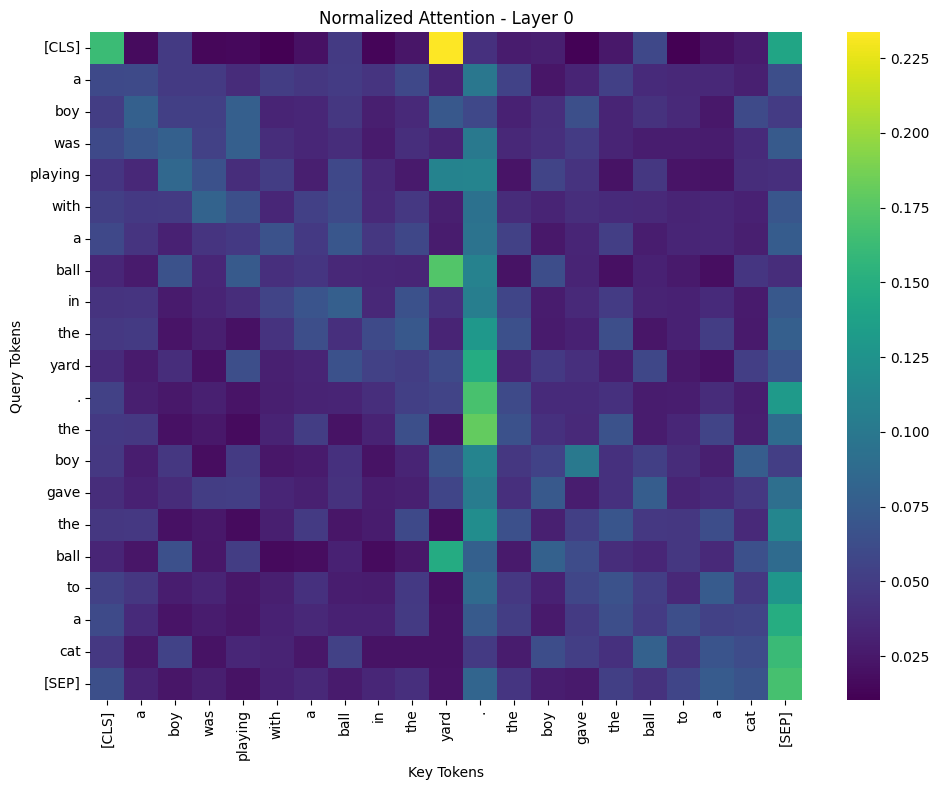

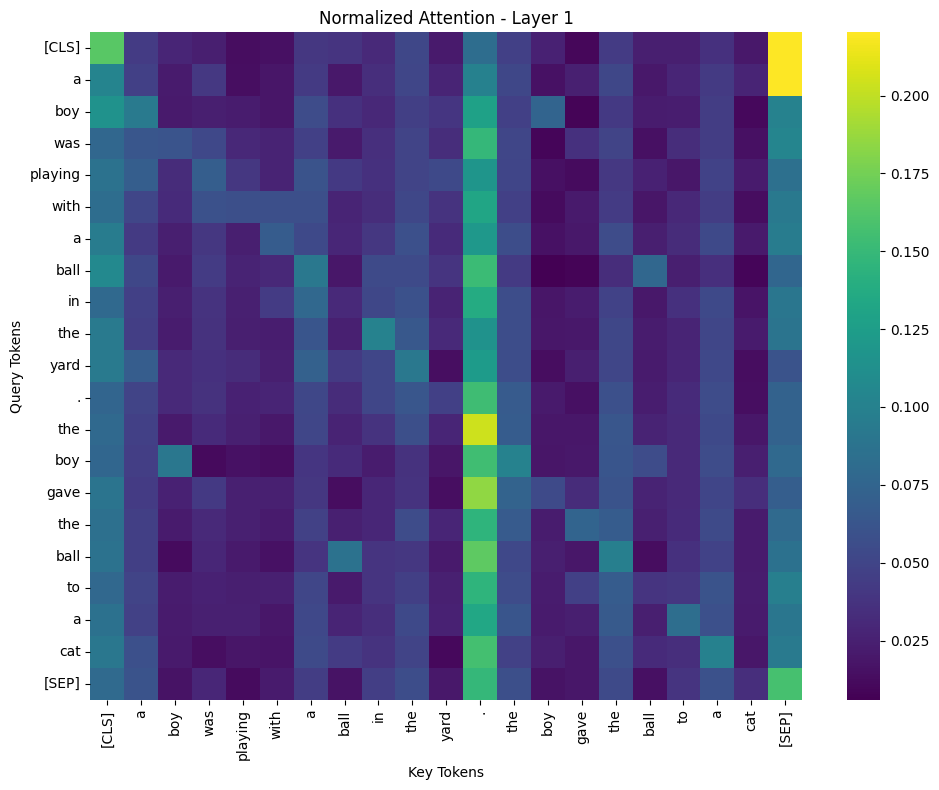

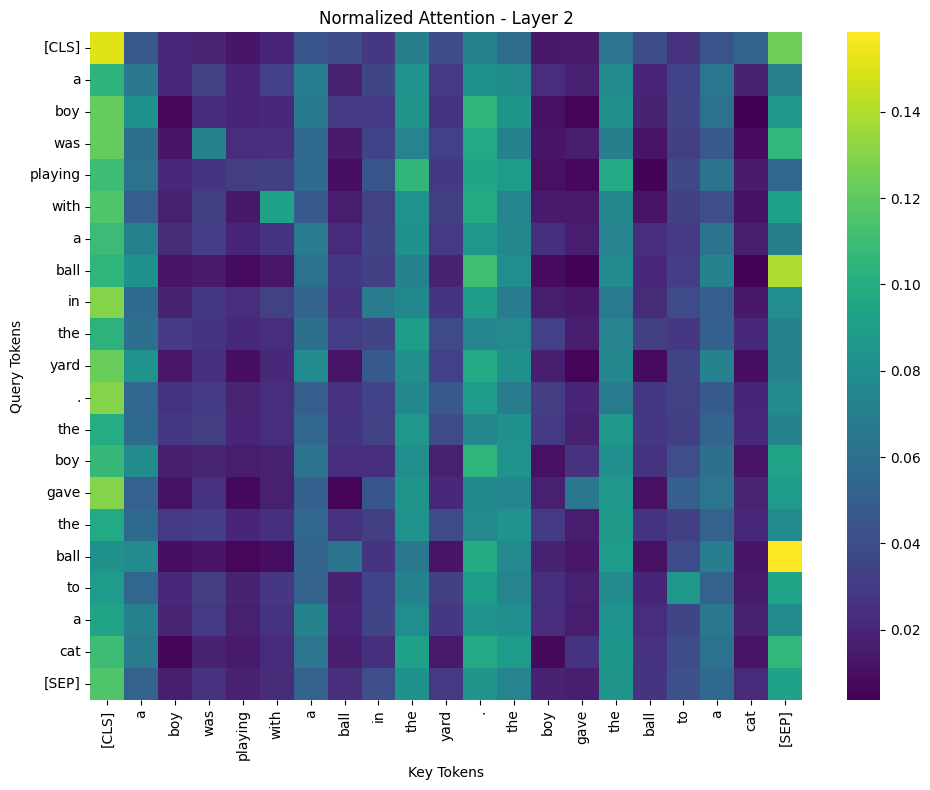

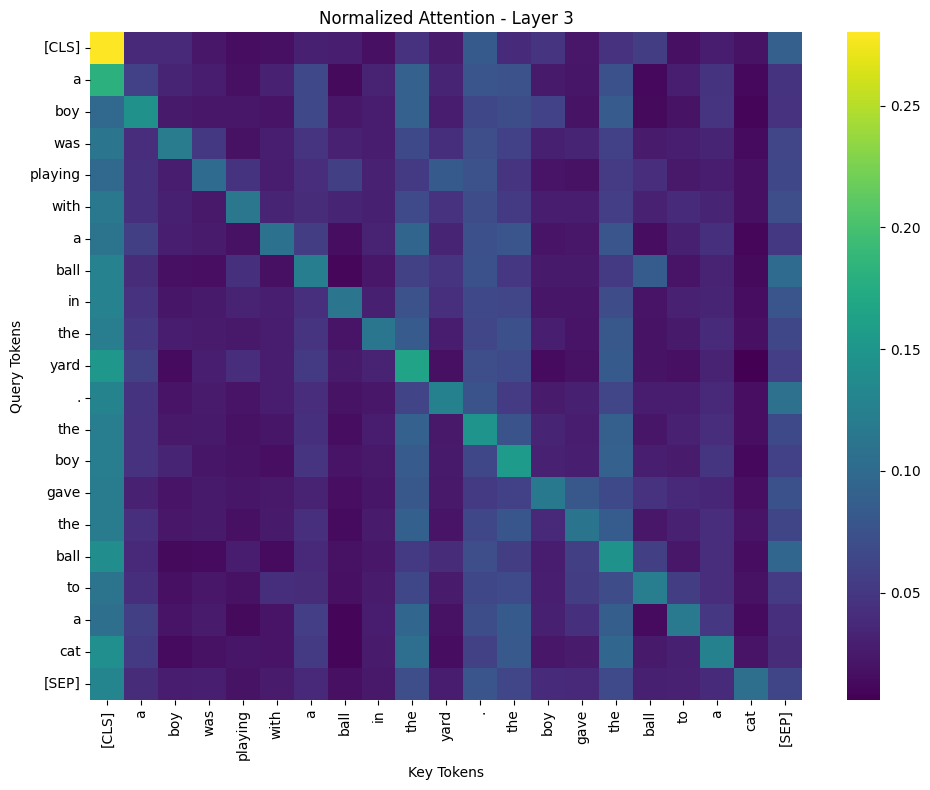

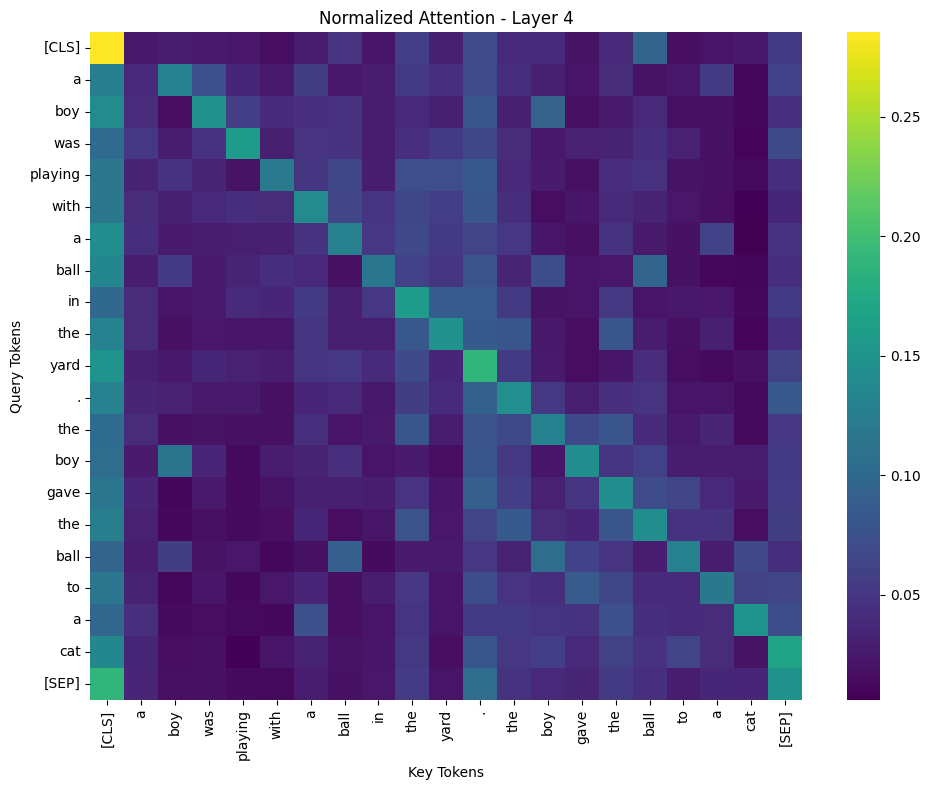

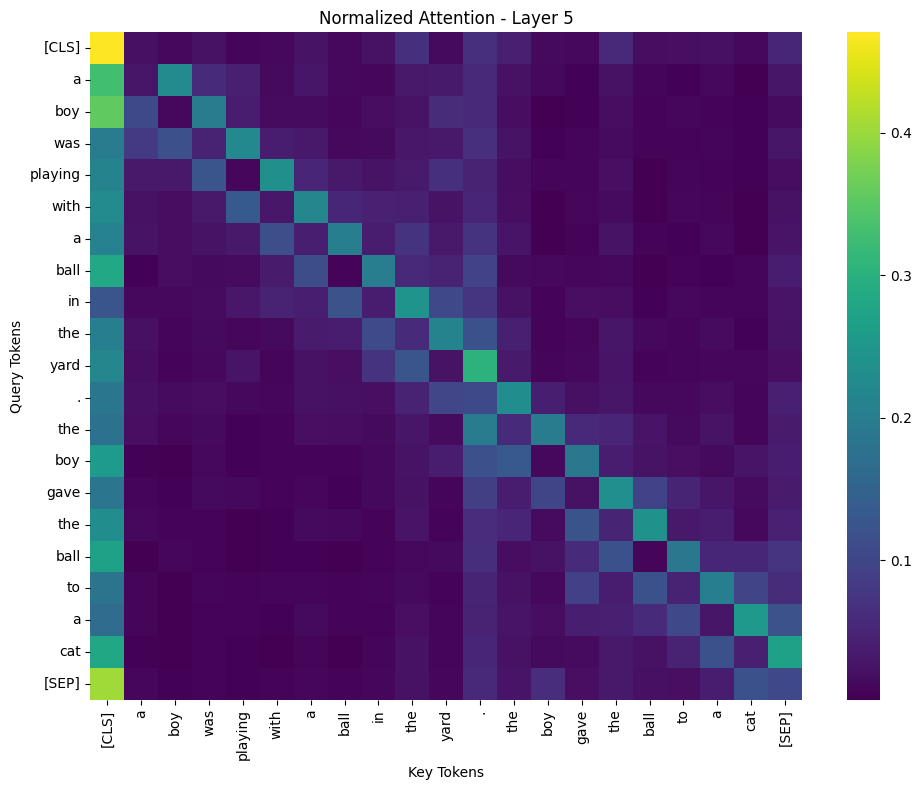

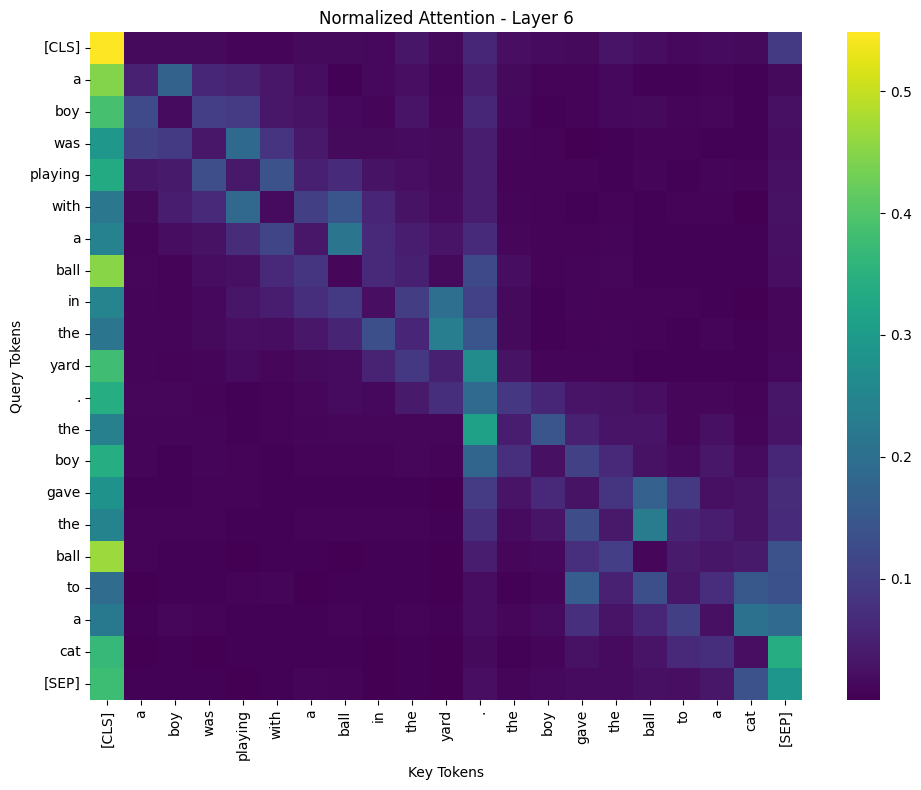

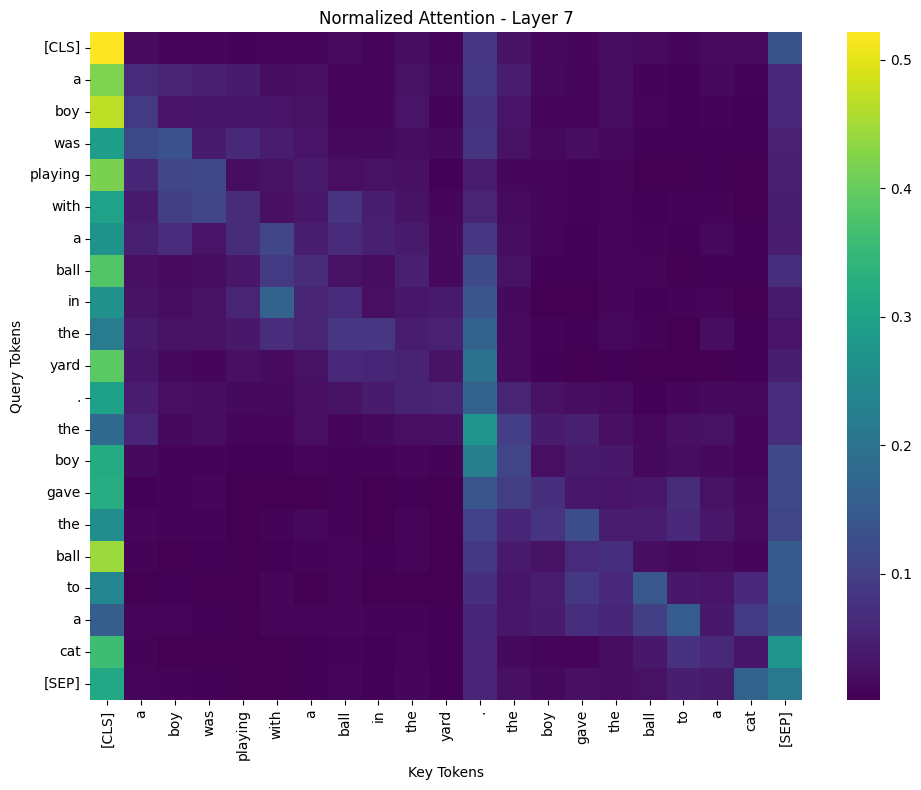

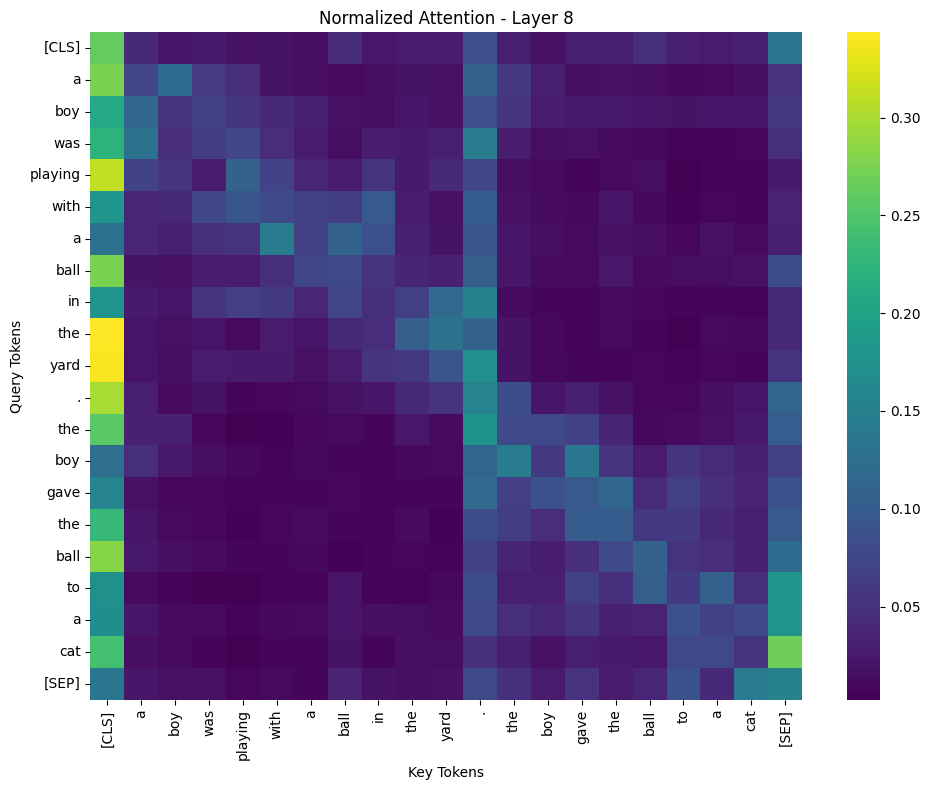

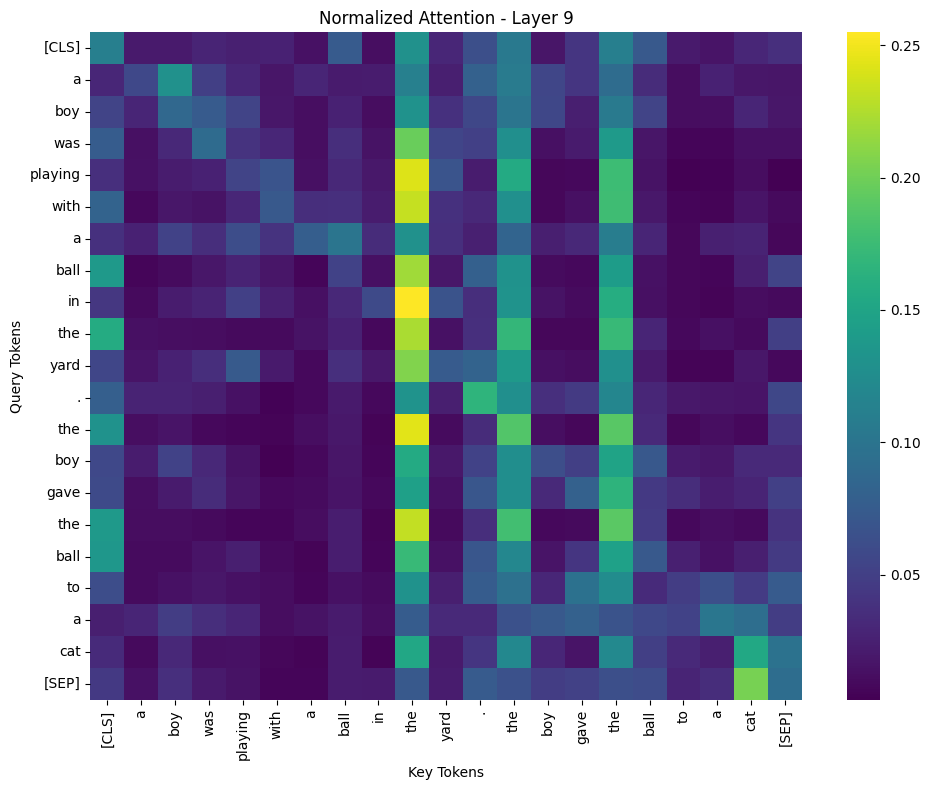

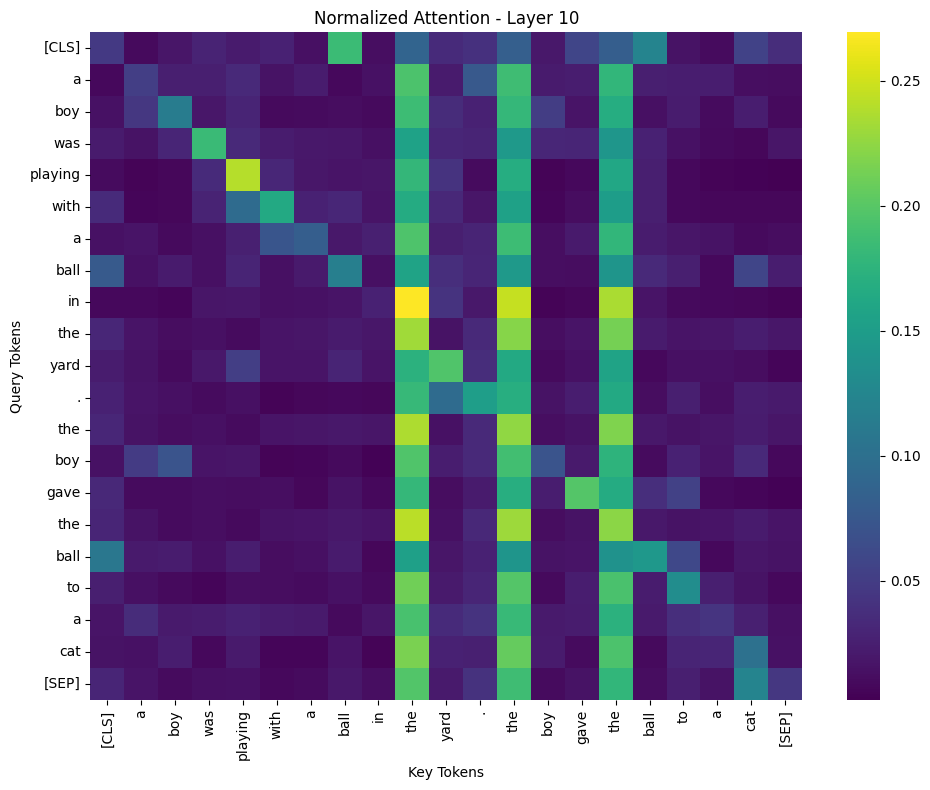

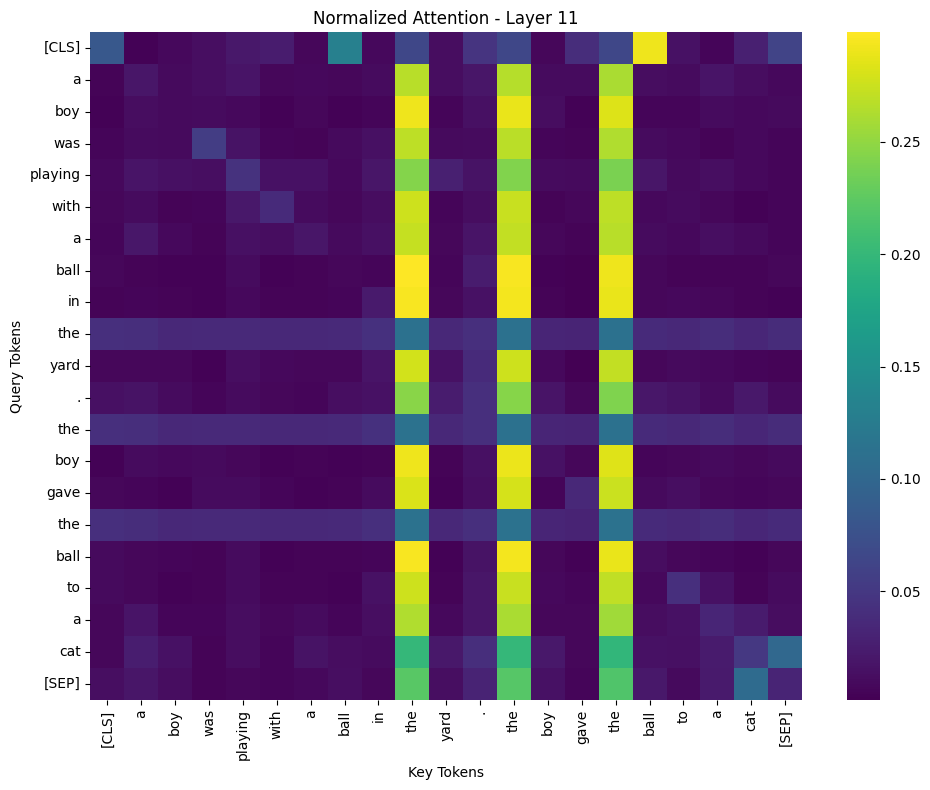

In [ ]:
import torch
import seaborn as sns
import matplotlib.pyplot as plt
from transformers import AutoTokenizer, AutoModel
from sentence_transformers import SentenceTransformer

def get_normalized_attentions(model, input_ids, attention_mask):
    # Forward pass with attention outputs
    outputs = model(input_ids=input_ids, attention_mask=attention_mask, output_attentions=True)
    attentions = outputs.attentions  # tuple of (batch_size, num_heads, seq_len, seq_len)

    normalized_layers = []
    for layer_attn in attentions:
        # Average over all heads (seq_len x seq_len)
        attn_avg_heads = layer_attn[0].mean(dim=0)
        row_sums = attn_avg_heads.sum(dim=1, keepdim=True) + 1e-10
        normalized = attn_avg_heads / row_sums
        normalized_layers.append(normalized.detach().cpu().numpy())  # fix: detach before .numpy()

    return normalized_layers

def plot_attention_heatmaps(normalized_layers, tokens):
    for i, layer_attn in enumerate(normalized_layers):
        plt.figure(figsize=(10, 8))
        sns.heatmap(layer_attn, xticklabels=tokens, yticklabels=tokens, cmap='viridis')
        plt.title(f'Normalized Attention - Layer {i}')
        plt.xlabel('Key Tokens')
        plt.ylabel('Query Tokens')
        plt.xticks(rotation=90)
        plt.yticks(rotation=0)
        plt.tight_layout()
        plt.show()

def main():
    model_name = "harish/CxGBERT-2-10000"
    #model_name = "ltg/ltg-bert-bnc"
    # Load model with manual attention fallback (future-proof)
    model = AutoModel.from_pretrained(
        model_name,
        trust_remote_code=True,
        #attn_implementation="eager"
    )

    tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
    model.eval()

    sentence = "A boy was playing with a ball in the yard. The boy gave the ball to a cat"
    inputs = tokenizer(sentence, return_tensors="pt")
    input_ids = inputs["input_ids"]
    attention_mask = inputs["attention_mask"]

    tokens = tokenizer.convert_ids_to_tokens(input_ids[0])
    normalized_layers = get_normalized_attentions(model, input_ids, attention_mask)
    plot_attention_heatmaps(normalized_layers, tokens)

if __name__ == "__main__":
    main()

BERT in Sentence Transformer

In [ ]:
def get_cls_attention_per_layer(model, input_ids, attention_mask):
    outputs = model(input_ids=input_ids, attention_mask=attention_mask, output_attentions=True)
    attentions = outputs.attentions  # List of tensors, shape: (batch_size, num_heads, seq_len, seq_len)

    cls_attns = []
    for layer_attn in attentions:
        # layer_attn: (1, num_heads, seq_len, seq_len)
        cls_attn = layer_attn[0, :, 0, :]  # Attention from [CLS] token (query=0) to all keys, for each head
        #cls_attn = layer_attn[0, :, :, 0]
        avg_cls_attn = cls_attn.mean(dim=0)  # Average across heads -> shape: (seq_len,)
        cls_attns.append(avg_cls_attn.detach().cpu().numpy())

    return cls_attns

def plot_cls_attention(cls_attns, tokens):
    for i, attn_vec in enumerate(cls_attns):
        plt.figure(figsize=(10, 2))
        sns.barplot(x=tokens, y=attn_vec, palette='viridis')
        plt.title(f"[CLS] Attention to Tokens - Layer {i}")
        plt.xticks(rotation=90)
        plt.ylabel("Attention Weight")
        plt.tight_layout()
        plt.show()

def main():
    model_name = "brjezierski/S3BERT"

    st_model = SentenceTransformer(model_name)
    tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)

    base_model = st_model[0].auto_model
    base_model.eval()

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    base_model.to(device)  # 🔧 move model to device

    sentence = "A boy was playing with a ball in the yard. The boy gave the ball to a cat"
    inputs = tokenizer(sentence, return_tensors="pt")

    # 🔧 move inputs to the same device
    input_ids = inputs["input_ids"].to(device)
    attention_mask = inputs["attention_mask"].to(device)

    tokens = tokenizer.convert_ids_to_tokens(input_ids[0])

    cls_attns = get_cls_attention_per_layer(base_model, input_ids, attention_mask)
    plot_cls_attention(cls_attns, tokens)

if __name__ == "__main__":
    main

##BERT CLS Attention/Attention to CLS
###uncomment for selection
*cls_attn = layer_attn[0, :, 0, :]  # Attention from [CLS] token (query=0) to all keys

*cls_attn = layer_attn[0, :, :, 0] # Attention to [CLS] token

In [9]:
import torch
import seaborn as sns
import matplotlib.pyplot as plt
from transformers import AutoTokenizer, AutoModel
from sentence_transformers import SentenceTransformer

def get_cls_attention_per_layer(model, input_ids, attention_mask):
    outputs = model(input_ids=input_ids, attention_mask=attention_mask, output_attentions=True)
    attentions = outputs.attentions  # List of tensors, shape: (batch_size, num_heads, seq_len, seq_len)

    cls_attns = []
    for layer_attn in attentions:
        # layer_attn: (1, num_heads, seq_len, seq_len)
        cls_attn = layer_attn[0, :, 0, :]  # Attention from [CLS] token (query=0) to all keys
        #cls_attn = layer_attn[0, :, :, 0] # Attention to [CLS] token
        avg_cls_attn = cls_attn.mean(dim=0)  # Average across heads -> shape: (seq_len,)
        cls_attns.append(avg_cls_attn.detach().cpu().numpy())

    return cls_attns

def plot_cls_attention(cls_attns, tokens):
    for i, attn_vec in enumerate(cls_attns):
        plt.figure(figsize=(10, 2.5))
        sns.barplot(x=tokens, y=attn_vec, palette='viridis')
        plt.title(f"[CLS] Attention to Tokens - Layer {i}")
        plt.xticks(rotation=90)
        plt.ylabel("Attention Weight")
        plt.ylim(0, 0.1)
        plt.tight_layout()
        plt.show()


##BERT CLS Attention in AutoModel

/tmp/ipython-input-11-3994698735.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=tokens, y=attn_vec, palette='viridis')


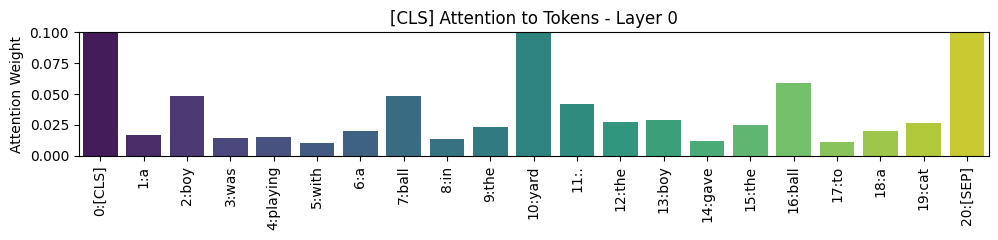

/tmp/ipython-input-11-3994698735.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=tokens, y=attn_vec, palette='viridis')


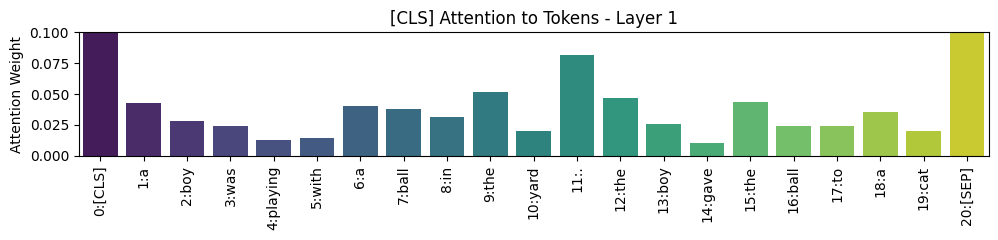

/tmp/ipython-input-11-3994698735.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=tokens, y=attn_vec, palette='viridis')


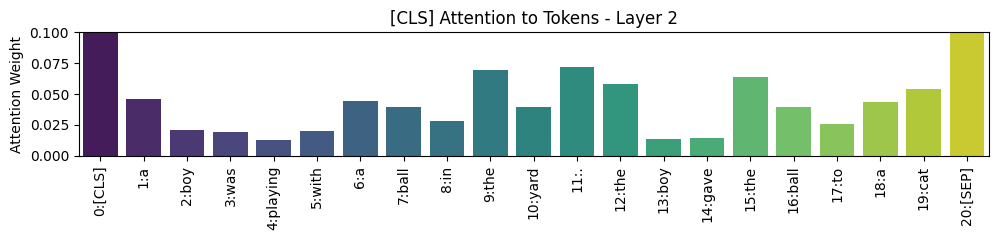

/tmp/ipython-input-11-3994698735.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=tokens, y=attn_vec, palette='viridis')


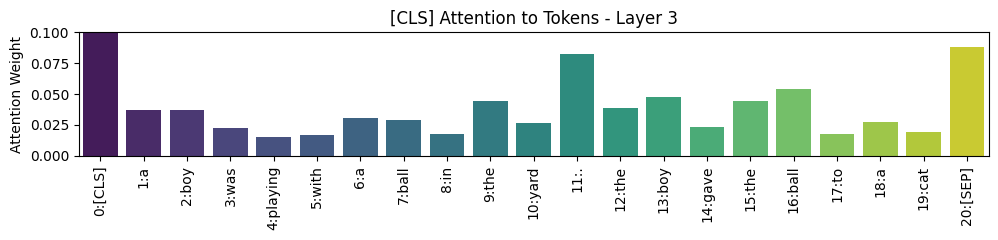

/tmp/ipython-input-11-3994698735.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=tokens, y=attn_vec, palette='viridis')


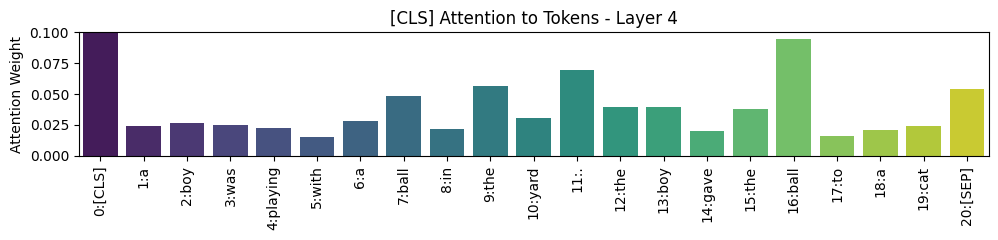

/tmp/ipython-input-11-3994698735.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=tokens, y=attn_vec, palette='viridis')


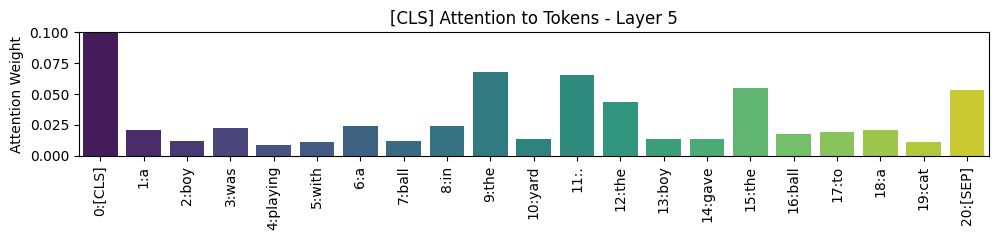

/tmp/ipython-input-11-3994698735.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=tokens, y=attn_vec, palette='viridis')


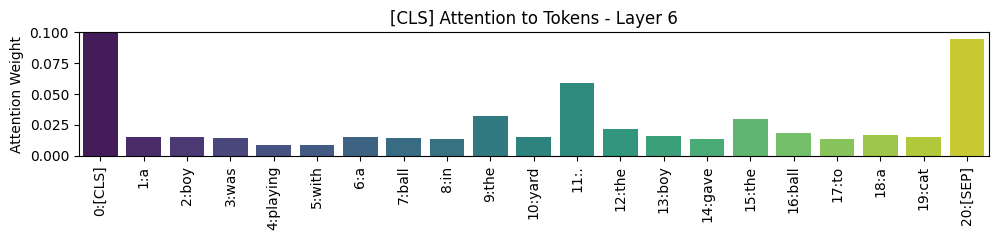

/tmp/ipython-input-11-3994698735.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=tokens, y=attn_vec, palette='viridis')


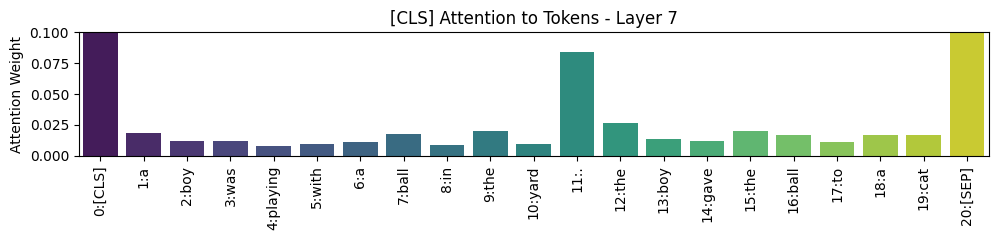

/tmp/ipython-input-11-3994698735.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=tokens, y=attn_vec, palette='viridis')


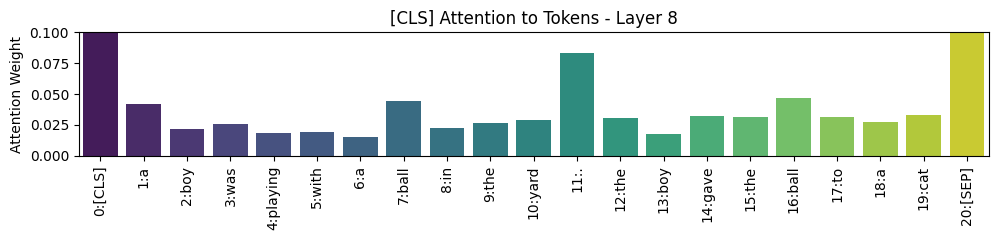

/tmp/ipython-input-11-3994698735.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=tokens, y=attn_vec, palette='viridis')


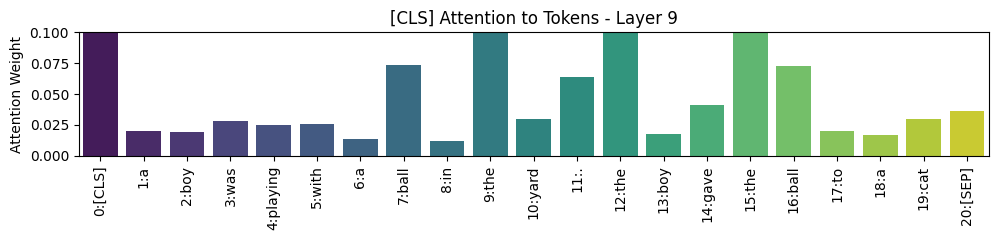

/tmp/ipython-input-11-3994698735.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=tokens, y=attn_vec, palette='viridis')


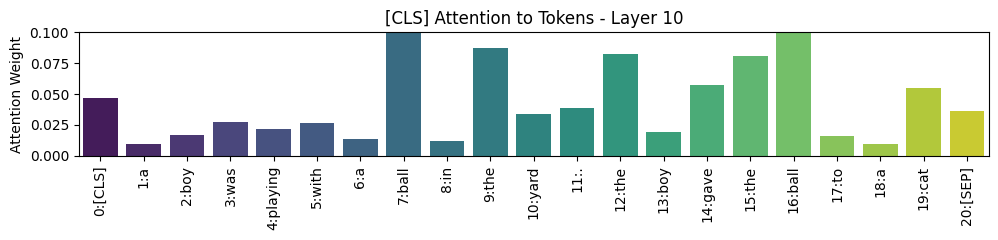

/tmp/ipython-input-11-3994698735.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=tokens, y=attn_vec, palette='viridis')


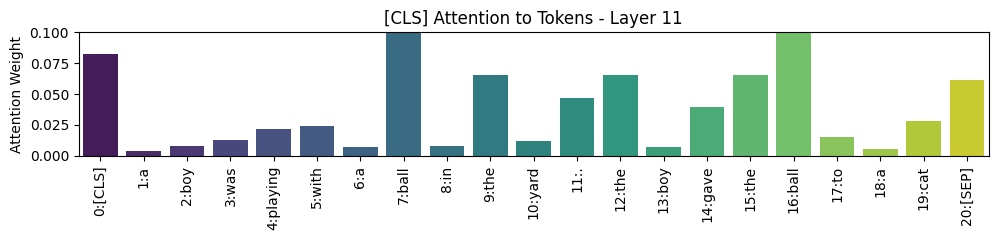

In [11]:
def get_cls_attention_per_layer(model, input_ids, attention_mask):
    outputs = model(input_ids=input_ids, attention_mask=attention_mask, output_attentions=True)
    attentions = outputs.attentions  # List of tensors, shape: (batch_size, num_heads, seq_len, seq_len)

    cls_attns = []
    for layer_attn in attentions:
        # layer_attn: (1, num_heads, seq_len, seq_len)
        cls_attn = layer_attn[0, :, 0, :]  # Attention from [CLS] token (query=0) to all keys
        #cls_attn = layer_attn[0, :, :, 0]
        avg_cls_attn = cls_attn.mean(dim=0)  # Average across heads -> shape: (seq_len,)
        cls_attns.append(avg_cls_attn.detach().cpu().numpy())

    return cls_attns

def plot_cls_attention(cls_attns, tokens):
    for i, attn_vec in enumerate(cls_attns):
        plt.figure(figsize=(10, 2.5))
        sns.barplot(x=tokens, y=attn_vec, palette='viridis')
        plt.title(f"[CLS] Attention to Tokens - Layer {i}")
        plt.xticks(rotation=90)
        plt.ylabel("Attention Weight")
        plt.ylim(0, 0.1)
        plt.tight_layout()
        plt.show()


def main():
    #model_name = "bert-base-uncased"
    model_name = "harish/CxGBERT-2-10000"
    #model_name = "ltg/ltg-bert-bnc"
    #model_name = "brjezierski/S3BERT"
    # Load model with manual attention fallback (future-proof)
    model = AutoModel.from_pretrained(
        model_name,
        trust_remote_code=True,
        #attn_implementation="eager"
    )

    tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
    model.eval()

    sentence = "A boy was playing with a ball in the yard. The boy gave the ball to a cat"
    inputs = tokenizer(sentence, return_tensors="pt")
    input_ids = inputs["input_ids"]
    attention_mask = inputs["attention_mask"]

    tokens = tokenizer.convert_ids_to_tokens(input_ids[0])
    tokens = [f"{i}:{tok}" for i, tok in enumerate(tokens)]
    cls_attns = get_cls_attention_per_layer(model, input_ids, attention_mask)
    plot_cls_attention(cls_attns, tokens)


if __name__ == "__main__":
    main()

##BERT CLS Attention in Sentence Transformer

/tmp/ipython-input-11-3994698735.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=tokens, y=attn_vec, palette='viridis')


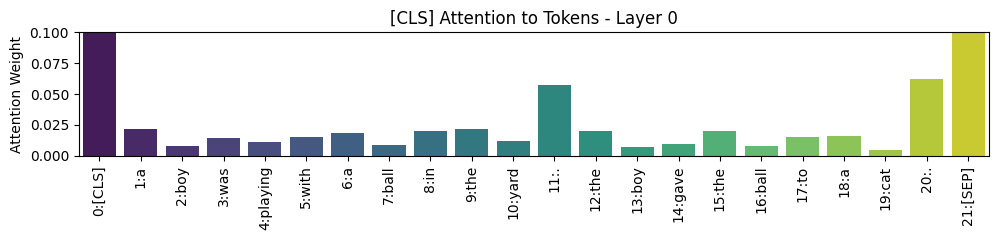

/tmp/ipython-input-11-3994698735.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=tokens, y=attn_vec, palette='viridis')


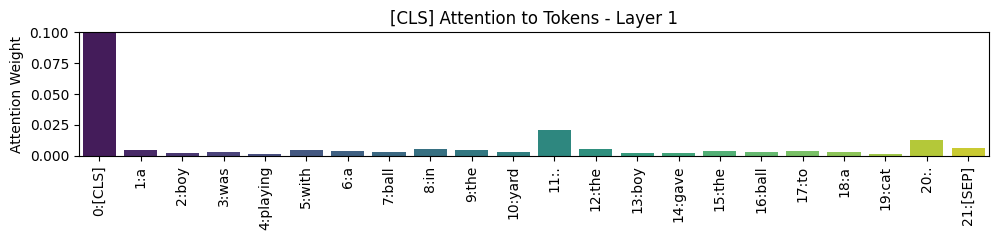

/tmp/ipython-input-11-3994698735.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=tokens, y=attn_vec, palette='viridis')


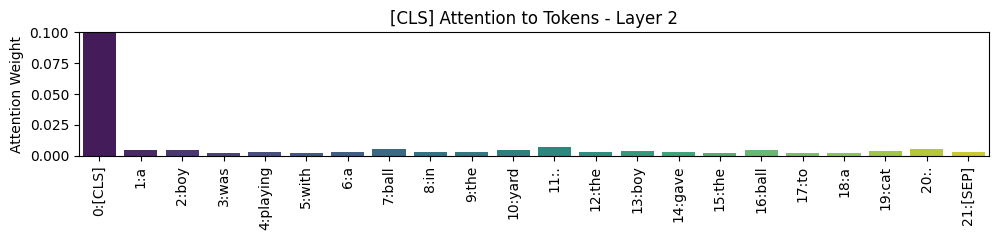

/tmp/ipython-input-11-3994698735.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=tokens, y=attn_vec, palette='viridis')


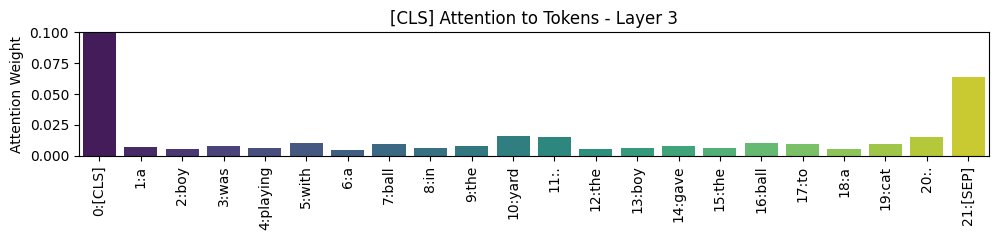

/tmp/ipython-input-11-3994698735.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=tokens, y=attn_vec, palette='viridis')


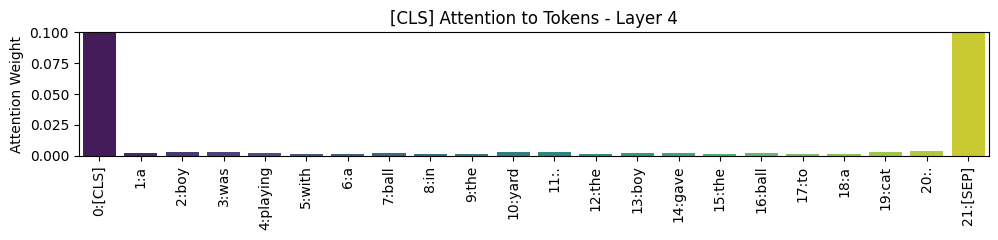

/tmp/ipython-input-11-3994698735.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=tokens, y=attn_vec, palette='viridis')


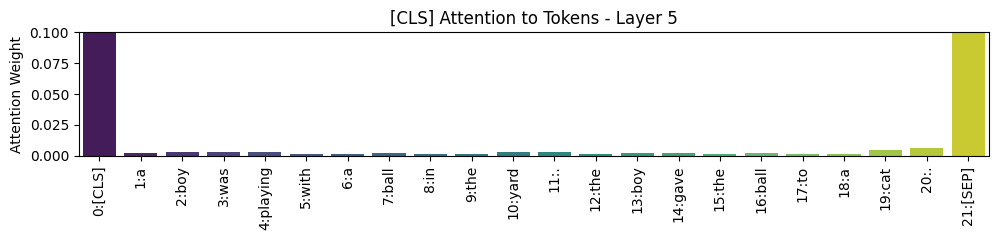

/tmp/ipython-input-11-3994698735.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=tokens, y=attn_vec, palette='viridis')


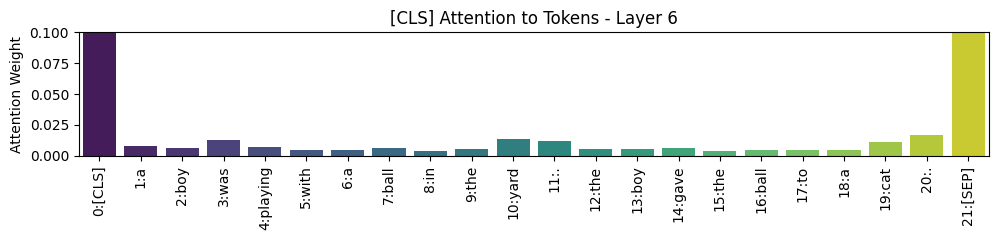

/tmp/ipython-input-11-3994698735.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=tokens, y=attn_vec, palette='viridis')


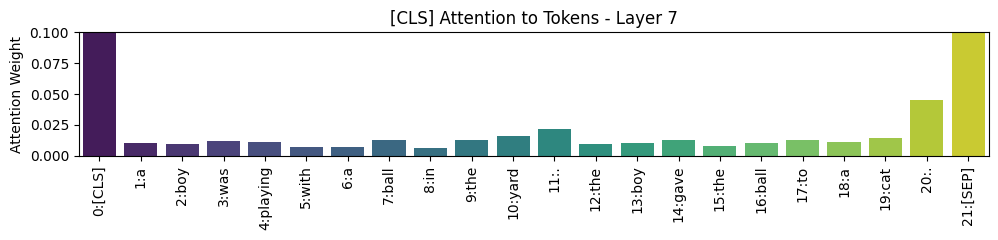

/tmp/ipython-input-11-3994698735.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=tokens, y=attn_vec, palette='viridis')


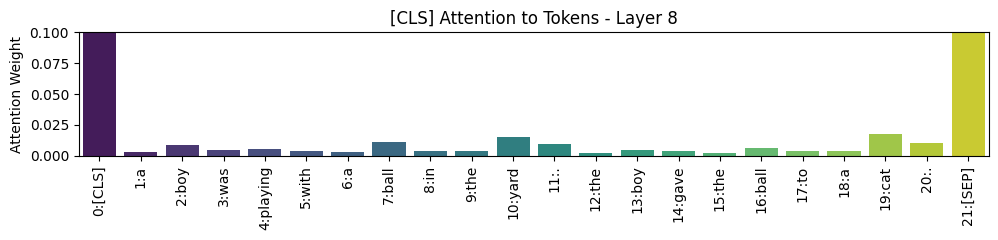

/tmp/ipython-input-11-3994698735.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=tokens, y=attn_vec, palette='viridis')


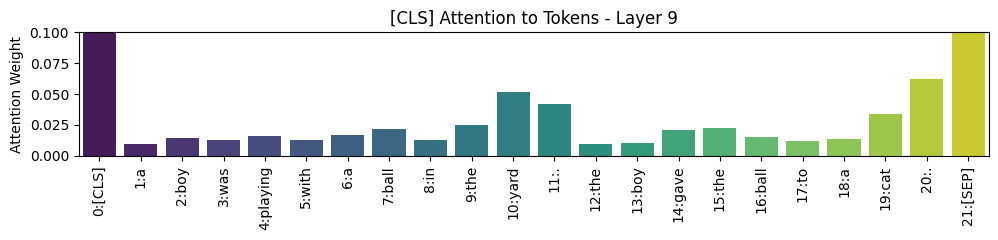

/tmp/ipython-input-11-3994698735.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=tokens, y=attn_vec, palette='viridis')


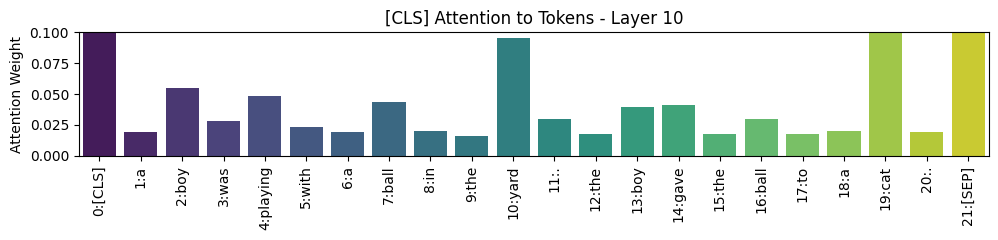

/tmp/ipython-input-11-3994698735.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=tokens, y=attn_vec, palette='viridis')


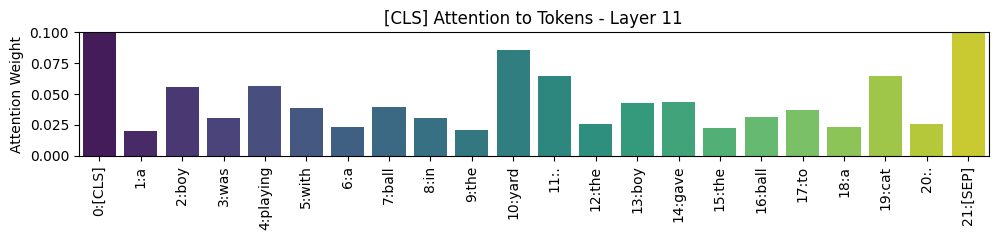

In [12]:
def main():
    model_name = "brjezierski/S3BERT"

    # Load sentence transformer model and tokenizer
    st_model = SentenceTransformer(model_name)
    tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)

    # Access the base transformer model
    base_model = st_model[0].auto_model
    base_model.eval()

    # Set device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    base_model.to(device)

    # Input sentence
    sentence = "A boy was playing with a ball in the yard. The boy gave the ball to a cat."
    inputs = tokenizer(sentence, return_tensors="pt")
    input_ids = inputs["input_ids"].to(device)
    attention_mask = inputs["attention_mask"].to(device)

    # Convert token IDs to readable tokens and add index prefix to make them unique
    tokens = tokenizer.convert_ids_to_tokens(input_ids[0])
    tokens = [f"{i}:{tok}" for i, tok in enumerate(tokens)]

    # Get CLS attention and plot
    cls_attns = get_cls_attention_per_layer(base_model, input_ids, attention_mask)
    plot_cls_attention(cls_attns, tokens)

if __name__ == "__main__":
    main()